## **By Mohamed Ali** 

In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv
/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv


## **Importing packages**

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import NuSVC
from sklearn.naive_bayes import GaussianNB
# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


## **Reading data & performing EDA**

In [22]:
twitter = pd.read_csv("/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv")
reddit = pd.read_csv("/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv")

In [23]:
twitter.head(5)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [24]:
reddit.head(5)

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64





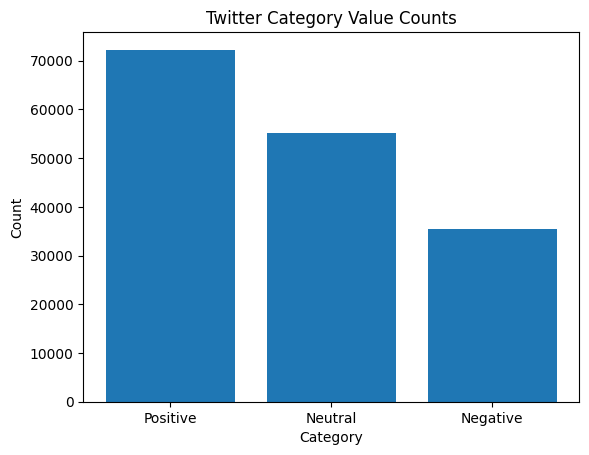

In [25]:
# Category distribution
print(twitter["category"].value_counts())
print("\n\n")

Tcounts = twitter["category"].value_counts()
Tcat = Tcounts.index.map({0:"Neutral", 1:"Positive", -1:"Negative"})
plt.bar(Tcat, Tcounts.values)
plt.title("Twitter Category Value Counts")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

category
 1    15830
 0    13142
-1     8277
Name: count, dtype: int64





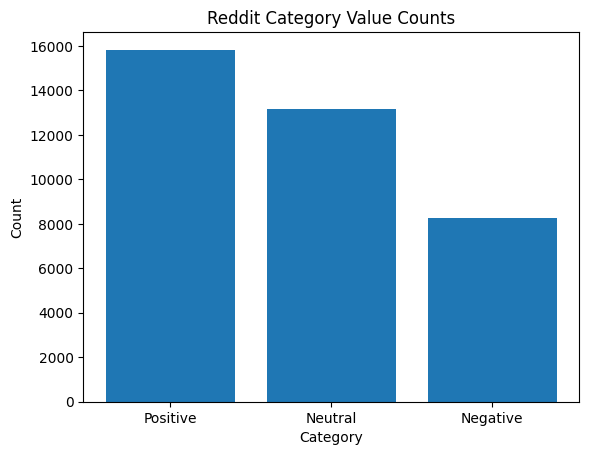

In [26]:
# Category distribution
print(reddit["category"].value_counts())
print("\n\n")

Rcounts = reddit["category"].value_counts()
Rcat = Rcounts.index.map({0:"Neutral", 1:"Positive", -1:"Negative"})
plt.bar(Rcat, Rcounts.values)
plt.title("Reddit Category Value Counts")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [27]:
# Exploring the shape of each one
print("Twitter has a shape of ", twitter.shape, "\n")
print("Reddit has a shape of", reddit.shape, "\n")

Twitter has a shape of  (162980, 2) 

Reddit has a shape of (37249, 2) 



Text(0, 0.5, 'Count')

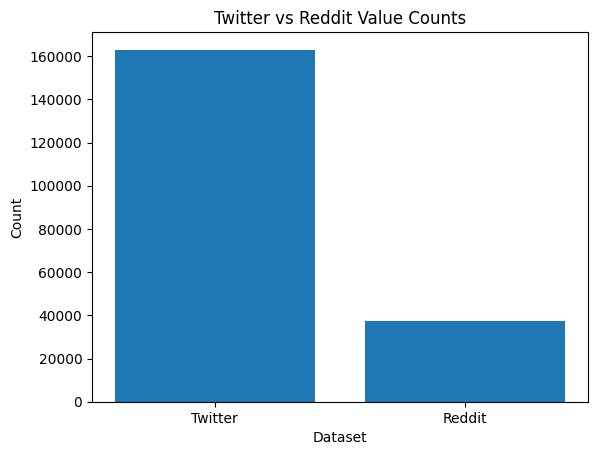

In [28]:
# Plotting the difference
plt.bar(["Twitter", "Reddit"], [twitter.shape[0], reddit.shape[0]])
plt.title("Twitter vs Reddit Value Counts")
plt.xlabel("Dataset")
plt.ylabel("Count")

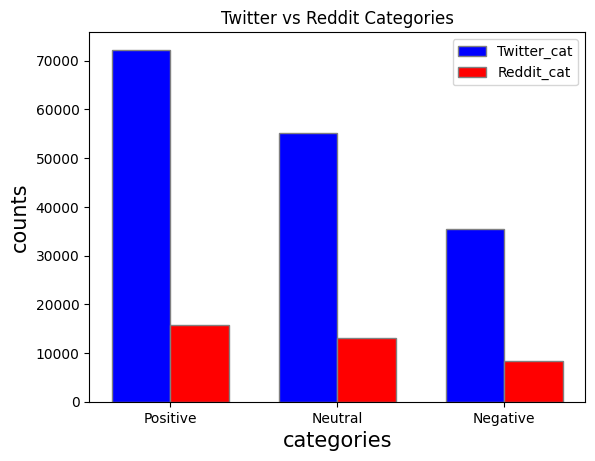

In [29]:
# The bar width
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(Tcat))
r2 = [x + bar_width for x in r1]

plt.bar(r1, Tcounts.values, color='b', width=bar_width, edgecolor='grey', label='Twitter_cat')
plt.bar(r2, Rcounts.values, color='r', width=bar_width, edgecolor='grey', label='Reddit_cat')

# Adding xticks
plt.title("Twitter vs Reddit Categories")
plt.xlabel('categories', fontsize=15)
plt.ylabel('counts', fontsize=15)
plt.xticks([r + bar_width/2 for r in range(len(Tcat))], Tcat)

plt.legend()
plt.show()


## **Preprocessing**

In [30]:
# NaN values before
print("Twitter has ", twitter.category.isna().sum(), " NaN values in the category column \n")
print("Reddit has ", reddit.category.isna().sum(), " NaN values in the category column \n")
print("Twitter has ", twitter.clean_text.isna().sum(), " NaN values in the text column \n")
print("Reddit has ", reddit.clean_comment.isna().sum(), " NaN values in the text column \n")

Twitter has  7  NaN values in the category column 

Reddit has  0  NaN values in the category column 

Twitter has  4  NaN values in the text column 

Reddit has  100  NaN values in the text column 



#### There are not many NaN values so we will just drop them

In [31]:
# Dropping the NaN values 
twitter = twitter.dropna()
reddit = reddit.dropna()

In [32]:
# NaN values After
print("Twitter has ", twitter.category.isna().sum(), " NaN values in the category column \n")
print("Reddit has ", reddit.category.isna().sum(), " NaN values in the category column \n")
print("Twitter has ", twitter.clean_text.isna().sum(), " NaN values in the text column \n")
print("Reddit has ", reddit.clean_comment.isna().sum(), " NaN values in the text column \n")

Twitter has  0  NaN values in the category column 

Reddit has  0  NaN values in the category column 

Twitter has  0  NaN values in the text column 

Reddit has  0  NaN values in the text column 



In [33]:
# Renaming the old columns names for merging
twitter = twitter.rename(columns={'clean_text':'text'})
reddit = reddit.rename(columns={'clean_comment':'text'})

# Merging the 2 datasets
df = pd.concat([twitter, reddit], ignore_index=True)
df

,text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
200113,jesus,0.0
200114,kya bhai pure saal chutiya banaya modi aur jab...,1.0
200115,downvote karna tha par upvote hogaya,0.0
200116,haha nice,1.0


In [34]:
# Cleaning step
sym = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(sym, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [35]:
# Applying the preprocess function
df.text = df.text.apply(lambda x: preprocess(x))
df

,text,category
0,modi promised minimum government maximum gover...,-1.0
1,talk nonsense continue drama vote modi,0.0
2,say vote modi welcome bjp told rahul main camp...,1.0
3,asking supporters prefix chowkidar names modi ...,1.0
4,answer among powerful world leader today trump...,1.0
...,...,...
200113,jesus,0.0
200114,kya bhai pure saal chutiya banaya modi aur jab...,1.0
200115,downvote karna tha par upvote hogaya,0.0
200116,haha nice,1.0


### Because the data is quite large it needed alot of resources and time and in the most of the time the sessions had been crashed so we will work on reddit dataset only

## **Preparing the data for the model**

In [63]:
# Applying the preprocess function
reddit.text = reddit.text.apply(lambda x: preprocess(x))
reddit

,text,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal wrappi...,0
4,benefit may want read living buddha living chr...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


In [36]:
# Splitting the data
X = reddit["text"]
y = reddit['category']
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=0)

print(X_train.shape)
print(X_test.shape)

(26004,)
(11145,)


In [37]:
# Vectorization to fit the model
vectorizer = TfidfVectorizer()
XV_train = vectorizer.fit_transform(X_train)
XV_test = vectorizer.transform(X_test)


## **Comparing Different models**

In [38]:
# Trying the NuSVC model
model = NuSVC()

# Train the model on the training data, not the test data
model.fit(XV_train, Y_train)  

# Model predictions to compare
y_pred = model.predict(XV_test)

# Evaluate the Model
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy}\n\n")
print("Classification Report:\n")
print(classification_report(Y_test, y_pred))


Accuracy: 0.8253028263795424


Classification Report:

              precision    recall  f1-score   support

          -1       0.89      0.58      0.70      2538
           0       0.79      0.95      0.86      3908
           1       0.84      0.86      0.85      4699

    accuracy                           0.83     11145
   macro avg       0.84      0.79      0.80     11145
weighted avg       0.83      0.83      0.82     11145



In [39]:
# Trying the GaussianNB model
model2 = GaussianNB()

# Train the model on the training data, not the test data
model2.fit(XV_train.toarray(), Y_train)

# Model predictions to compare
y_pred2 = model2.predict(XV_test.toarray())

# Evaluate the Model
accuracy = accuracy_score(Y_test, y_pred2)
print(f"Accuracy: {accuracy}\n\n")
print("Classification Report:\n")
print(classification_report(Y_test, y_pred2))


Accuracy: 0.5278600269179003


Classification Report:

              precision    recall  f1-score   support

          -1       0.33      0.51      0.40      2538
           0       0.70      0.66      0.68      3908
           1       0.57      0.43      0.49      4699

    accuracy                           0.53     11145
   macro avg       0.53      0.53      0.52     11145
weighted avg       0.56      0.53      0.54     11145



In [40]:
# Trying the RandomForestClassifier model
model3 = RandomForestClassifier()

# Train the model on the training data, not the test data
model3.fit(XV_train, Y_train)

# Model predictions to compare
y_pred3 = model3.predict(XV_test)

# Evaluate the Model
accuracy = accuracy_score(Y_test, y_pred3)
print(f"Accuracy: {accuracy}\n\n")
print("Classification Report:\n")
print(classification_report(Y_test, y_pred3))


Accuracy: 0.7640197397936295


Classification Report:

              precision    recall  f1-score   support

          -1       0.93      0.28      0.43      2538
           0       0.80      0.92      0.86      3908
           1       0.72      0.90      0.80      4699

    accuracy                           0.76     11145
   macro avg       0.81      0.70      0.69     11145
weighted avg       0.79      0.76      0.73     11145



### **We can see that NuSVC is the best till now comparing to other models**

In [62]:
# Random testing
e = vectorizer.transform(["I hate this",
                          "I love that",
                          "the worst ",
                          "the best day ever",
                          "that's cold",
                          "I walked home"
                         ])

e_predictions = pd.DataFrame(model.predict(e))
e_predictions["predictions"] = e_predictions.apply(lambda x : x.map({0:"Neutral",
                                                        1:"Positive",
                                                        -1:"Negative"}))

e_predictions

,0,predictions
0,-1,Negative
1,1,Positive
2,-1,Negative
3,1,Positive
4,-1,Negative
5,0,Neutral


## **End Of The Task**